<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/05_gradient_echos/notebooks/further_demo-RF_spoiling_with_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gradient echoes and SSFP exercises: The S- Signal for RF-Spoiling**

This is rather a demonstration than an exercises.
You will see here the influence of diffusion on the S- signal when it comes to RF-spoiling.
Without diffusion, The S- signal is not zero.
When diffusion is incorporated to the signal simulation, the S- signal vanishes.
See below the brain image you obtain after running the notebook. One half of the brain is without diffusion, the other one with diffusion (only the latter with vanishing signal).


# Initialization

In [ ]:
import importlib
if importlib.util.find_spec('pypulseq') is None:
    !pip install -q mrzerocore git+https://github.com/imr-framework/pypulseq.git

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
!pip install MRzeroCore
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
import pypulseq as pp

!wget -nc https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
from utils import animate, simulate_2d, recon_cartesian_3d, plot_nd

File ‘utils.py’ already there; not retrieving.



# **Create, simulate, and reconstruct sequence**

**GRE Sequence definition**

Timing check passed successfully


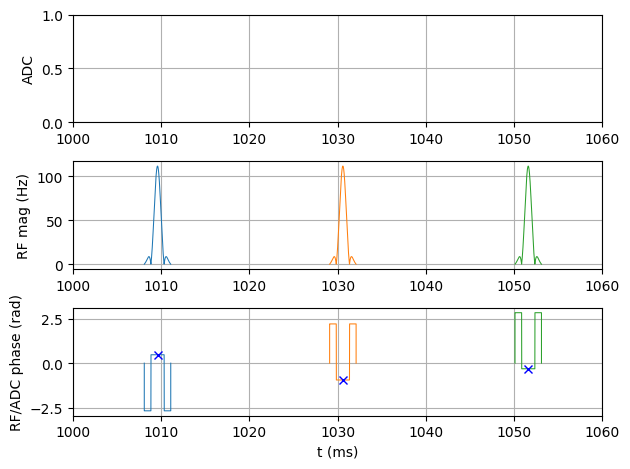

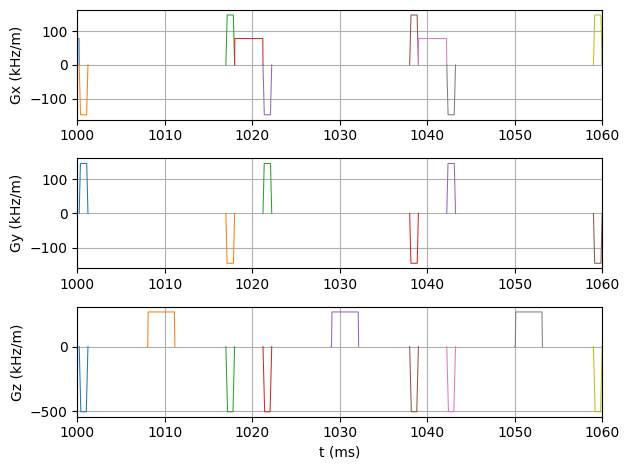

Number of blocks: 984
Number of events:
RF:    164
Gx:    492
Gy:    328
Gz:    492
ADC:     64
Delay:      0
Sequence duration: 3.444000 s
TE: 0.008425 s
TR: 0.021000 s
Flip angle: 30.00 deg
Unique k-space positions (aka cols, rows, etc.): 64 64 
Dimensions: 2
Spatial resolution: 1.33 mm
Spatial resolution: 4.00 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check passed successfully
Max gradient: 147978 145349 502058 Hz/m == 3.48 3.41 11.79 mT/m
Max slew rate: 3906250000 1038205980 5333333333 Hz/m/s == 91.75 24.38 125.27 T/m/s
Max absolute gradient: 543218 Hz/m == 12.76 mT/m
Max absolute slew rate: 5.33332e+09 Hz/m/s == 125.27 T/m/s


In [ ]:
plot = True
write_seq = True
seq_filename = "gre_3d.seq"

# ======
# SETUP
# ======

# Define FOV and resolution
fov = [256e-3, 256e-3, 5e-3]
Nx = 64
Ny = 64
Nz = 1
alpha = 30  # flip angle
TR = 20e-3  # Repetition time
TE = 10e-3  # Echo time
dummy_scans = 100 # Number of dummy repetitions

ro_os = 1 # Readout oversampling

# Here are the modifications that are needed to fulfil the different excercises
# For the RF-Spoiling, see below in the sequence block

# FISP
#A = -0.5
#C = 0.5
#rf_inc = 0

# bSSFP
#A = -0.5
#C = -0.5
#rf_inc = 180
# To make the banding artefact visible, change C to, e.g., C = -0.4
# To shift the banding artefact, change rf_inc.

# PSIF
A = 0.5
C = -0.5
rf_inc = 0

# k= -2 sequence
#A = 1.5
#C = -1.5
#rf_inc = 0


readout_duration = 3.2e-3 # Readout duration (sec)
pe_duration = 1e-3 # Duration of phase encoding gradients (sec)

# Create system object
system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=150,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

# Create a new sequence object
seq = pp.Sequence(system=system)

# ======
# CREATE EVENTS
# ======
rf, gz, _ = pp.make_sinc_pulse(
    flip_angle=alpha * math.pi / 180,
    duration=3e-3,
    slice_thickness=fov[2],
    apodization=0.42,
    time_bw_product=4,
    system=system,
    return_gz=True
)

# Define other gradients and ADC events
delta_kx = 1 / fov[0]
delta_ky = 1 / fov[1]
delta_kz = 1 / fov[2]

gx = pp.make_trapezoid(channel="x", flat_area=Nx * delta_kx, flat_time=readout_duration, system=system)
adc = pp.make_adc(num_samples=Nx * ro_os, duration=gx.flat_time, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel="x", area=-gx.area / 2, duration=pe_duration, system=system)

gx_spoil = pp.make_trapezoid(channel="x", area=2 * Nx * delta_kx, system=system)
gz_spoil = pp.make_trapezoid(channel="z", area=4 / fov[2], system=system)

# Phase encoding
phase_areas_y = (np.arange(Ny) - Ny // 2) * delta_ky
phase_areas_z = (np.arange(Nz) - Nz // 2) * delta_kz

# Phase encoding table with YZ order (outer loop = Z, inner loop = Y)
phase_encode_table = [(y,z) for z in range(len(phase_areas_z)) for y in range(len(phase_areas_y))]

# Calculate timing
delay_TE = (
    np.ceil(
        (
            TE
            - (pp.calc_duration(gz, rf) - pp.calc_rf_center(rf)[0] - rf.delay)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx) / 2
            - pp.eps
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
delay_TR = (
    np.ceil(
        (
            TR
            - pp.calc_duration(rf, gz)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx)
            - delay_TE
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)

# Exercises: Possible that you need to comment out these
assert delay_TE >= 0
assert delay_TR >= pp.calc_duration(gx_spoil, gz_spoil)

N_pe = len(phase_encode_table)

# ======
# CONSTRUCT SEQUENCE
# ======

# Initialize label values
last_lin = 0
last_slc = 0

# Initialize RF phase cycling
rf_phase = 0


# Loop over phase encodes and define sequence blocks
for i in range(-dummy_scans, N_pe):

    # rf spoiling

    # no rf spoiling
    #rf_phase = (rf_phase + rf_inc) % 360.0

    rf.phase_offset = rf_phase / 180 * np.pi
    rf_phase = i*(i-1)*117/2
    adc.phase_offset = rf_phase / 180 * np.pi

    # RF excitation and slice/slab selection gradient
    seq.add_block(rf, gz)

    # Wait for TE
    seq.add_block(pp.make_delay(delay_TE))

    # Phase encoding gradients, combined with slice selection rephaser
    pe_index_y, pe_index_z = phase_encode_table[max(i, 0)]
    #
    gx_pre = pp.make_trapezoid(channel="x", area=A * gx.area, duration=pe_duration, system=system)
    gy_pre = pp.make_trapezoid(channel="y", area=phase_areas_y[pe_index_y], duration=pe_duration, system=system)
    gz_pre = pp.make_trapezoid(channel="z", area=phase_areas_z[pe_index_z] - gz.area / 2, duration=pe_duration, system=system)
    seq.add_block(gx_pre, gy_pre, gz_pre)

    # Readout, do not enable ADC/labels for dummy acquisitions
    if i < 0:
        seq.add_block(gx)
    else:
        # Readout with LIN (Y) and SLC (Z) labels (increment relative to previous label value)
        seq.add_block(gx, adc, pp.make_label('LIN', 'INC', pe_index_y - last_lin), pp.make_label('SLC', 'INC', pe_index_z - last_slc))

    # Balance phase encoding and slice selection gradients
    gy_post = pp.make_trapezoid(channel="y", area=-phase_areas_y[pe_index_y], duration=pe_duration, system=system) #jl
    gz_post = pp.make_trapezoid(channel="z", area=-phase_areas_z[pe_index_z] - gz.area / 2, duration=pe_duration, system=system) #jl
    gx_post = pp.make_trapezoid(channel="x", area=C * gx.area, duration=pe_duration, system=system)
    seq.add_block(gx_post, gy_post, gz_post)

    # wait for TR
    seq.add_block(pp.make_delay(delay_TR))

    # Update previous labels
    last_lin = pe_index_y
    last_slc = pe_index_z


# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# ======
# VISUALIZATION
# ======
if plot:
    #seq.plot()
    nn=6
    seq.plot(time_range=np.array([50, 53])*TR, time_disp="ms")


# Very optional slow step, but useful for testing during development e.g. for the real TE, TR or for staying within
# slew-rate limits
print(seq.test_report())

# =========
# WRITE .SEQ
# =========
seq.set_definition(key="FOV", value=fov)

if write_seq:
    # Prepare the sequence output for the scanner
    seq.set_definition(key="Name", value="gre_3d")
    seq.write(seq_filename)

**Plot k-space trajectory**

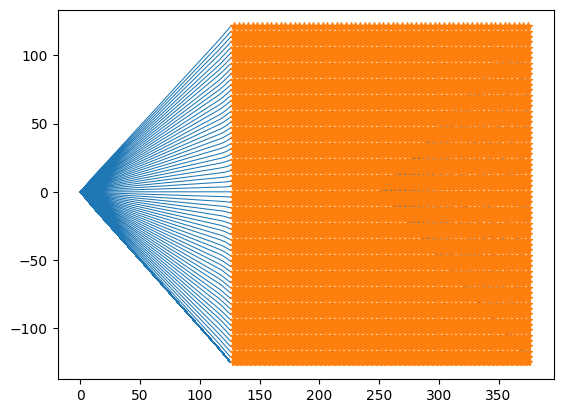

In [ ]:
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'*');

**Check gradient 0th moments over one TR**

In [ ]:
# Excitation events are filled with NaN in k_traj, find trajectory before second NaN
# Note: Because this is one sample before the excitation, if a gradient is enabled, the moment calculation will be off by the area of one sample (amplitude * grad_raster_time)!
end_of_tr_inds = np.flatnonzero(np.isnan(k_traj[0])) - 1
k_traj_after_first_tr = k_traj[:, end_of_tr_inds[1]]

print(f'X moment: {k_traj_after_first_tr[0]: 8.2f}/m   {k_traj_after_first_tr[0]/(Nx*delta_kx): 8.2f} cycles/voxel')
print(f'Y moment: {k_traj_after_first_tr[1]: 8.2f}/m   {k_traj_after_first_tr[1]/(Ny*delta_ky): 8.2f} cycles/voxel')
print(f'Z moment: {k_traj_after_first_tr[2]: 8.2f}/m   {k_traj_after_first_tr[2]/(Nz*delta_kz): 8.2f} cycles/voxel')

X moment:   251.56/m       1.01 cycles/voxel
Y moment:     0.00/m       0.00 cycles/voxel
Z moment:    -0.53/m      -0.00 cycles/voxel


**Animate trajectory**

In [ ]:
ani = animate(seq, show=False, dt=seq.duration()[0] / 10, plot_window=seq.duration()[0], fps=10, show_progress=True)
from IPython.display import HTML
HTML(ani.to_html5_video())

  0%|          | 0/10 [00:00<?, ?it/s]

**Run MR-zero simulation**

The code below simulates the whole sequence, and shows the magnitude of the raw k-space profiles in acquisition order.

/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


Calculating repetition 164 / 164 - done


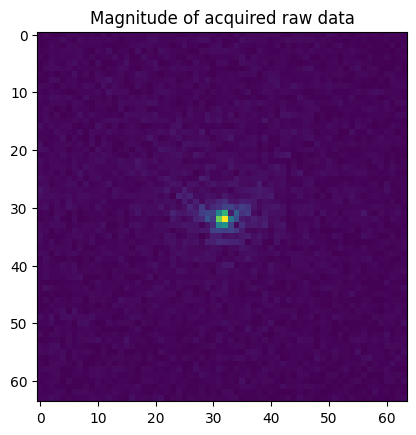

In [ ]:
# Simulate sequence
kdata = simulate_2d(seq, sim_size=[128,128], noise_level=0.5, n_coils=1, B0_scale=1)

# Display raw data profiles
plt.figure()
plt.imshow(abs(kdata[0]))
plt.title('Magnitude of acquired raw data');

**Reconstruct simulated data**

Detected labels in the sequence!
Automatically detected matrix size: ['SLC', 'LIN', 'ADC'] [1, 64, 64]


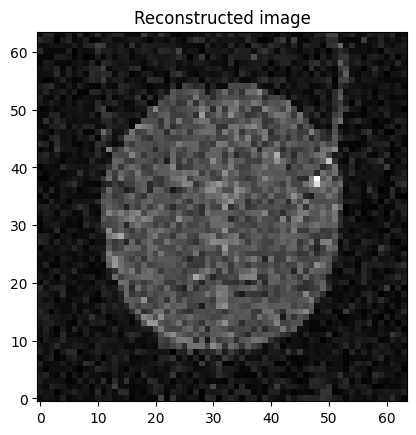

In [ ]:
rec = recon_cartesian_3d(kdata, seq)

plot_nd(rec)
plt.title('Reconstructed image');

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


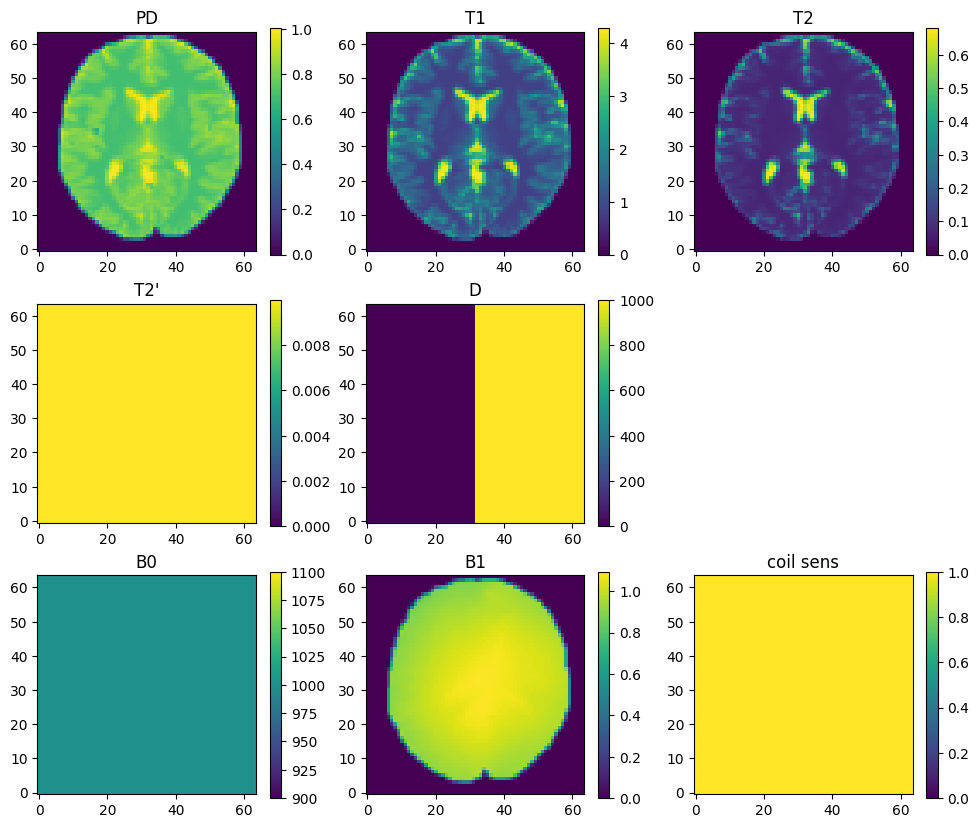

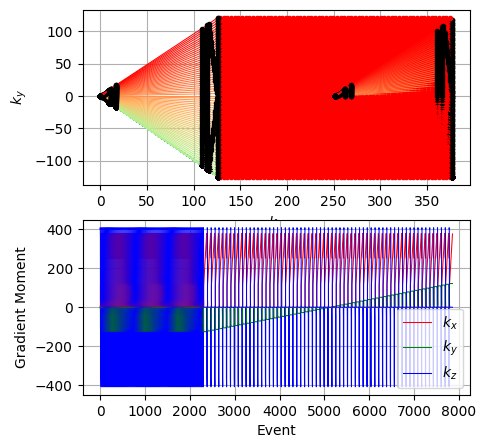

Calculating repetition 164 / 164 - done


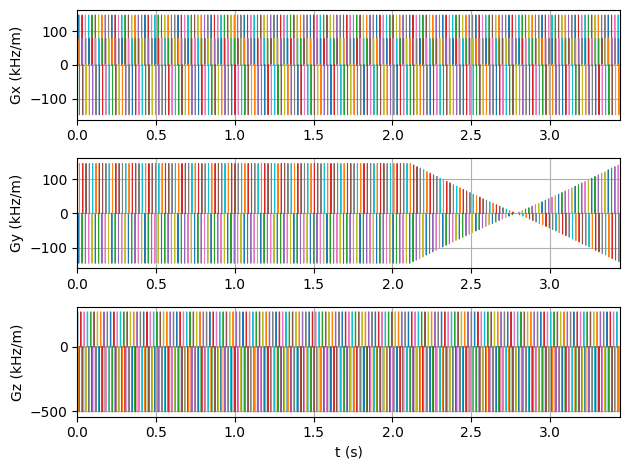

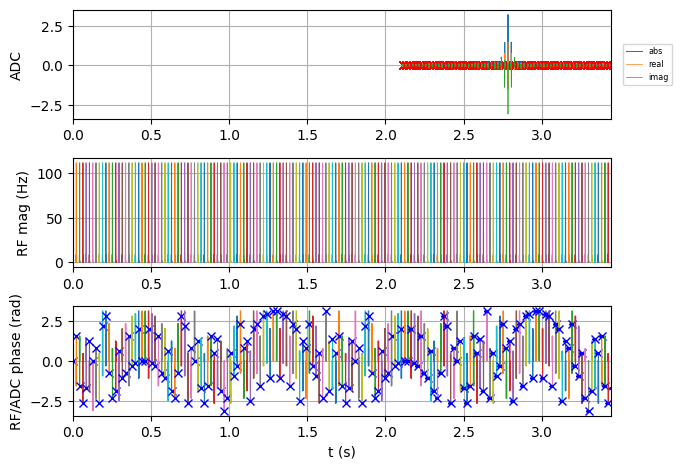

In [ ]:
#@title simulation (advanced)
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
import MRzeroCore as mr0
import torch
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.T2dash[:] = 10e-3
#obj_p.D=obj_p.T2*100
#obj_p.D[:] = 10000

# (ii) insert rectangular region with diffusion
# typical brain tumor ADC values are around ~1.5 * 10^-3 mm^2/s,
# which lies between GM/WM and CSF (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3000221)
if 1:
    # construct image region with diffusion > 0
    for ii in range(Nx//2, Nx):
        for jj in range(0, Ny):
            obj_p.D[ii, jj] = torch.tensor(1.0*1000)


obj_p.B0 =obj_p.B0*0+ 1000    # alter the B0 inhomogeneity
# Store PD for comparison
PD = obj_p.PD
B0 = obj_p.B0

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq0 = mr0.Sequence.import_file(seq_filename)
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 1000, 1e-5)
signal = mr0.execute_graph(graph, seq0, obj_p)

# PLOT sequence with signal in the ADC subplot
#sp_adc, t_adc = mr0.util.pulseq_plot(seq,signal=signal.numpy())


seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq,signal)
plt.show()

Detected labels in the sequence!
Automatically detected matrix size: ['SLC', 'LIN', 'ADC'] [1, 64, 64]


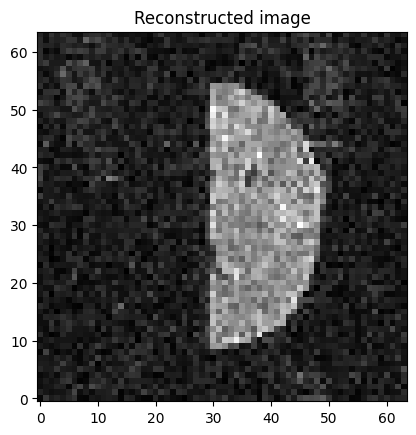

In [ ]:
kdata = signal.reshape(-1, Nx, 1).numpy().transpose(2,0,1) # Reshape to [N_coils, N_meas, N_adc]

noise_level=0.04
kdata += noise_level * (np.random.randn(*kdata.shape) + 1j * np.random.randn(*kdata.shape))
rec = recon_cartesian_3d(kdata, seq)

plot_nd(rec)
plt.title('Reconstructed image');